<h1 class=heading> Support Vector Machine (SVM)

<h3 class=heading> Import Libraries

In [35]:
import os, sys, time, copy, glob
from tqdm.notebook import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

import cv2

<h3 class=heading> Load the data

In [2]:
# Set the parent folder
path = '/home/sysadm/Desktop/3ml/ZhangLabData/CellData/chest_xray'

In [3]:
# Collect all file paths for all classes
train_path_normal = glob.glob(os.path.join(path, 'train/NORMAL/*'))
train_path_pneumonia = glob.glob(os.path.join(path, 'train/PNEUMONIA/*'))
test_path_normal = glob.glob(os.path.join(path, 'test/NORMAL/*'))
test_path_pneumonia = glob.glob(os.path.join(path, 'test/PNEUMONIA/*'))

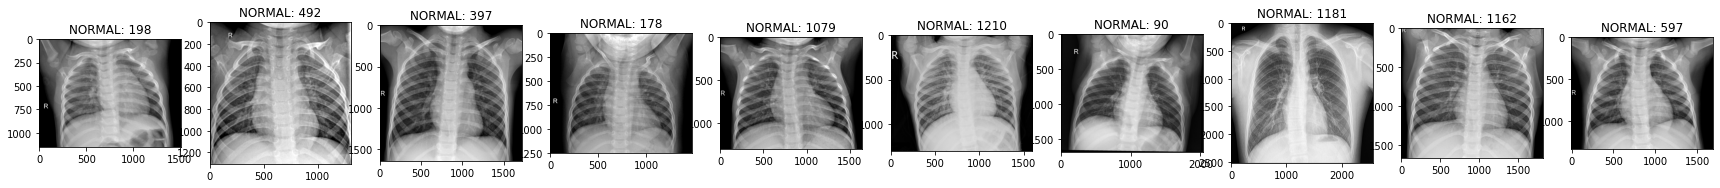

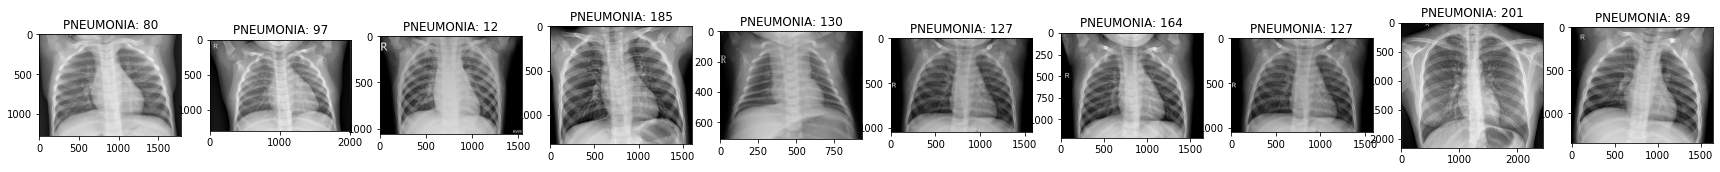

In [4]:
plt.figure(figsize = (30,3))
for i in enumerate(np.random.randint(1, len(train_path_normal),10)):
    plt.subplot(1,10,i[0]+1)
    plt.imshow(cv2.imread(train_path_normal[i[1]]), cmap = 'gray')
    plt.title('NORMAL: ' + str(i[1]))
    
plt.figure(figsize = (30,3))
for i in enumerate(np.random.randint(1, len(test_path_normal),10)):
    plt.subplot(1,10,i[0]+1)
    plt.imshow(cv2.imread(test_path_normal[i[1]]), cmap = 'gray')
    plt.title('PNEUMONIA: ' + str(i[1]))

In [5]:
# Read the label information
y_train = np.repeat(['NORMAL','PNEUMONIA'],[len(train_path_normal),len(train_path_pneumonia)])
y_test = np.repeat(['NORMAL','PNEUMONIA'],[len(test_path_normal),len(test_path_pneumonia)])

In [6]:
# Print the unique values
print(np.unique(y_train,return_counts=True))
print(np.unique(y_test,return_counts=True))

(array(['NORMAL', 'PNEUMONIA'], dtype='<U9'), array([1349, 3883]))
(array(['NORMAL', 'PNEUMONIA'], dtype='<U9'), array([234, 390]))


<h3 class=heading> Build Model and Measure Performance

In [7]:
# Read the train data
n_train = len(train_path_normal+train_path_pneumonia)
paths_train = train_path_normal+train_path_pneumonia
X_train = np.zeros((n_train, 32*32))
for i in tqdm(range(n_train), desc = 'Read train images'):
    img = cv2.imread(paths_train[i], cv2.IMREAD_GRAYSCALE)
    img_resize = cv2.resize(img, (32, 32), interpolation = cv2.INTER_AREA)
    X_train[i] = img_resize.flatten()
# Read the test data
n_test = len(test_path_normal+test_path_pneumonia)
paths_test = test_path_normal+test_path_pneumonia
X_test = np.zeros((n_test, 32*32))
for i in tqdm(range(n_test), desc = 'Read train images'):
    img = cv2.imread(paths_test[i], cv2.IMREAD_GRAYSCALE)
    img_resize = cv2.resize(img, (32, 32), interpolation = cv2.INTER_AREA)
    X_test[i] = img_resize.flatten()

Read train images:   0%|          | 0/5232 [00:00<?, ?it/s]

Read train images:   0%|          | 0/624 [00:00<?, ?it/s]

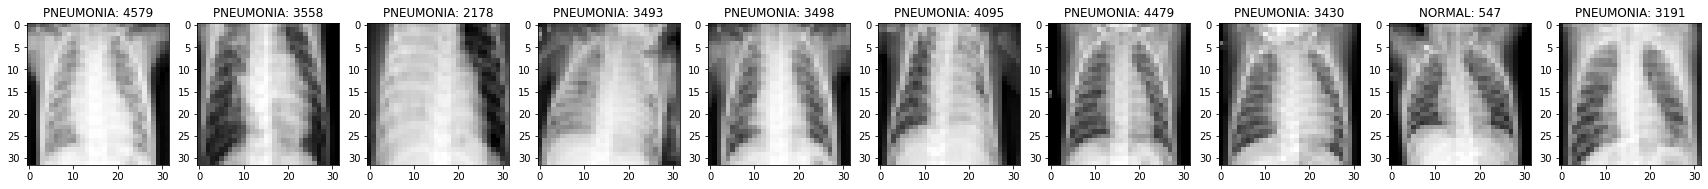

In [8]:
np.random.seed(12345);
idx = np.random.randint(1, len(paths_train), 10)
plt.figure(figsize = (30,3))
for i in enumerate(idx):
    plt.subplot(1,10,i[0]+1)
    plt.imshow(X_train[i[1]].reshape(32,32), cmap = 'gray')
    plt.title(y_train[i[1]] + ': ' + str(i[1]))

In [9]:
scaler = preprocessing.StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)

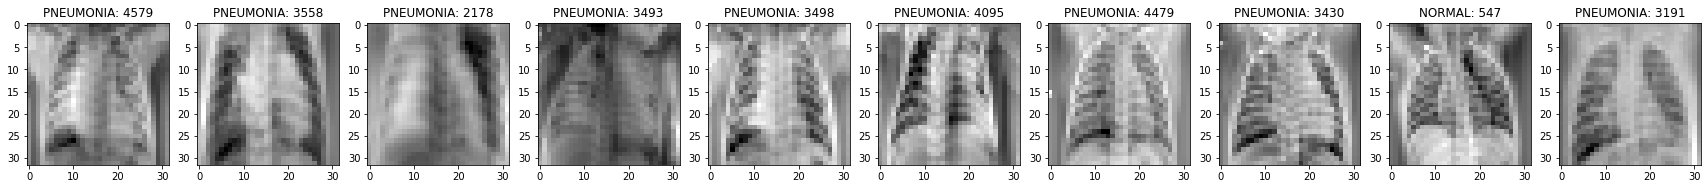

In [10]:
plt.figure(figsize = (30,3))
for i in enumerate(idx):
    plt.subplot(1,10,i[0]+1)
    plt.imshow(X_train[i[1]].reshape(32,32), cmap = 'gray')
    plt.title(y_train[i[1]] + ': ' + str(i[1]))

<h4 class=heading> probability = True

In [36]:
svc = svm.SVC(probability=True)
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)

In [37]:
print('The train accuracy is {}%'.format(np.round(svc.score(X_train,y_train)*100,2)))
print('The test accuracy is {}%'.format(np.round(svc.score(X_test,y_test)*100,2)))

The train accuracy is 98.99%
The test accuracy is 62.5%


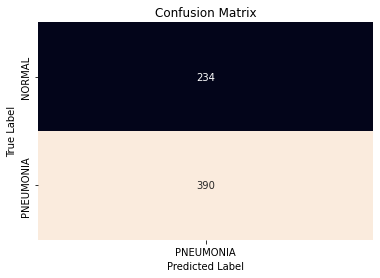

In [38]:
sns.heatmap(pd.crosstab(y_test, y_pred, rownames = ['True Label'], colnames = ['Predicted Label']), annot = True, fmt = '.0f', cbar = False) ; plt.title('Confusion Matrix');

In [40]:
print(np.unique(y_pred,return_counts=True))

(array(['PNEUMONIA'], dtype='<U9'), array([624]))


<h6 style='color:red; font-size:14pt; text-align:right;'> Test accuracy is not good. So, now we change some parameter in the model (e.g. solver, max_iter, pennalty, tolerance).

In [17]:
def logisticReg(max_iter, solver = 'newton-cg'):
    logit = LogisticRegression(solver=solver,max_iter=max_iter)
    logit.fit(X_train, y_train)
    train_score = np.round(logit.score(X_train,y_train)*100,2)
    test_score = np.round(logit.score(X_test,y_test)*100,2)
    return (train_score, test_score)

In [25]:
score = []
for i in tqdm(np.arange(200, 1200, 100), desc='Multiple Model Traning'):
    p, q = logisticReg(i)
    score.append([i, p, q])

Multiple Model Traning:   0%|          | 0/10 [00:00<?, ?it/s]

<h6 style='color:red; font-size:14pt; text-align:right;'> After train the model with different number of iteration, the model accuracy is exactly same upto two decimal place. So, we would try with different solver.

<h4 class=heading> solver='liblinear', max_iter=1000

In [27]:
logit = LogisticRegression(solver='liblinear',max_iter=1000)
logit.fit(X_train, y_train)
y_pred = logit.predict(X_test)

In [28]:
print('The train accuracy is {}%'.format(np.round(logit.score(X_train,y_train)*100,2)))
print('The test accuracy is {}%'.format(np.round(logit.score(X_test,y_test)*100,2)))

The train accuracy is 99.98%
The test accuracy is 70.99%


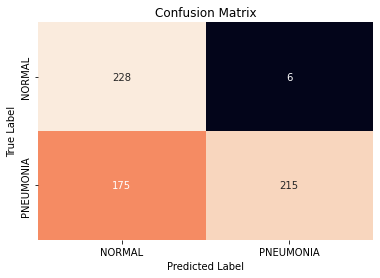

In [29]:
sns.heatmap(pd.crosstab(y_test, y_pred, rownames = ['True Label'], colnames = ['Predicted Label']), annot = True, fmt = '.0f', cbar = False) ; plt.title('Confusion Matrix');

<h4 class=heading> solver='lbfgs', max_iter=1000

In [32]:
logit = LogisticRegression(solver='lbfgs',max_iter=1000)
logit.fit(X_train, y_train)
y_pred = logit.predict(X_test)

In [33]:
print('The train accuracy is {}%'.format(np.round(logit.score(X_train,y_train)*100,2)))
print('The test accuracy is {}%'.format(np.round(logit.score(X_test,y_test)*100,2)))

The train accuracy is 99.98%
The test accuracy is 69.87%


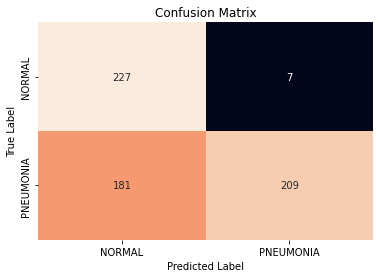

In [34]:
sns.heatmap(pd.crosstab(y_test, y_pred, rownames = ['True Label'], colnames = ['Predicted Label']), annot = True, fmt = '.0f', cbar = False) ; plt.title('Confusion Matrix');

<h6 style='color:skyblue; font-size:14pt; text-align:right;'> Conclusion: Solver named 'sag', 'saga', 'lbfgs' is not converge for this problem. So, with (32x32) inter area resized images, liblinear solver gives us 71% testing accuracy. 

In [15]:
from IPython.core.display import HTML
def css_styling():
    styles = open("./../www/styles/custom.css", "r").read()
    return HTML(styles)
css_styling()